In [0]:
%config InlineBackend.figure_formats = ['svg']
import sys
sys.path.insert(1, '../')

import matplotlib.pyplot as plt
from os import path

from deployment_instance.Result import ExperimentResult
from src.ingest_data import ingest_experiment_results
from src.query_data import get_exfiltration_time_df, get_data_exfiltration_cdf, total_control_host_capture_times
from statistics import mean
import seaborn as sns
# set seaborn font size
sns.set_theme(font_scale=1.5)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.color_palette("pastel")

import pandas as pd

In [1]:
# Equifax layered
dfs_layered = ingest_experiment_results(path.join('data/EquifaxLarge/layered/dfs/dfs_layered_d10_h50'))
targeted_layered = ingest_experiment_results(path.join('data/EquifaxLarge/layered/targeted/targeted_layered_d10_h50'))
mislead_layered = ingest_experiment_results(path.join('data/EquifaxLarge/layered/mislead/mislead_layered_d10_h50'))

# Equifax reactive simple
equifax_reactive_simple = ingest_experiment_results(path.join('data/EquifaxLarge/reactive/equifax/baseline_reactiveStandalone_d10_h0'))
dfs_reactive_simple = ingest_experiment_results(path.join('data/EquifaxLarge/reactive/dfs/dfs_reactiveSimple'))
targeted_reactive_simple = ingest_experiment_results(path.join('data/EquifaxLarge/reactive/targeted/targeted_reactiveSimple'))
persistentdfs_reactive_simple = ingest_experiment_results(path.join('data/EquifaxLarge/reactive/persistent_dfs/persistentdfs_reactiveSimple'))
darkside_reactive_simple = ingest_experiment_results(path.join('data/EquifaxLarge/reactive/darkside/darkside_reactiveSimple'))

equifax_reactive_simple_data = {}
equifax_reactive_simple_data.update(equifax_reactive_simple)
equifax_reactive_simple_data.update(dfs_reactive_simple)
equifax_reactive_simple_data.update(targeted_reactive_simple)
equifax_reactive_simple_data.update(persistentdfs_reactive_simple)
equifax_reactive_simple_data.update(darkside_reactive_simple)


In [2]:
equifax_standalone_d10_data_times = get_exfiltration_time_df(equifax_standalone_d10_data, 48, 'basic_honeypot')
equifax_standalone_d10_h50_data_times = get_exfiltration_time_df(equifax_standalone_d10_h50_data, 48, 'mixed_deception')
equifax_layered_data_times = get_exfiltration_time_df(equifax_layered_data, 48, 'layered')
equifax_reactive_simple_data_times = get_exfiltration_time_df(equifax_reactive_simple_data, 48, 'reactive_simple')


# Merge dfs into 1 df
equifax_data = pd.concat([equifax_standalone_d10_data_times, equifax_standalone_d10_h50_data_times, equifax_layered_data_times, equifax_reactive_simple_data_times])

In [3]:
equifax_data_agg = (
    equifax_data.groupby('experiment')
    .agg({'percent_files_exfiltrated': {'mean'}, 'time_exfiltrated': 'median', 'defender': 'first', 'attacker': 'first'})
    .reset_index()
)
equifax_data_agg



,experiment,percent_files_exfiltrated,time_exfiltrated,defender,attacker
,,mean,time_exfiltrated,defender,attacker
0,baseline_layered_d10_h50,100.000000,54.250349,layered,EquifaxBaselineAttacker
1,baseline_reactiveStandalone_d10_h0,99.166667,39.564166,reactive_simple,EquifaxBaselineAttacker
2,baseline_standalone_d10_h0,100.000000,41.804096,basic_honeypot,EquifaxBaselineAttacker
3,baseline_standalone_d10_h50,100.000000,43.585041,mixed_deception,EquifaxBaselineAttacker
4,darkside_layered_d10_h50,99.166667,43.343499,layered,darkside
5,darkside_reactiveSimple,60.000000,56.743759,reactive_simple,darkside
6,darkside_standalone_d10_h0,100.000000,42.460860,basic_honeypot,darkside
7,darkside_standalone_d10_h50,100.000000,43.412399,mixed_deception,darkside
8,dfs_layered_d10_h50,93.333333,74.541169,layered,network_DFS


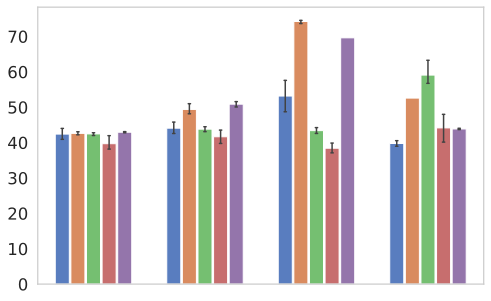

In [4]:
# change seaborn colors
sns.set_palette("muted")
# Remove rows where time_exfiltrated is 0
filtered_equifax_data = equifax_data[equifax_data['percent_files_exfiltrated'] > 90]

# Bar plot
plt.figure(figsize=(8, 5))
defender_order = ['basic_honeypot', 'mixed_deception', 'layered', 'reactive_simple']
attacker_order = ['EquifaxBaselineAttacker', 'network_DFS', 'darkside', 'targeted', 'persistent_dfs_planner']
sns.barplot(x='defender', y='time_exfiltrated', hue='attacker', data=filtered_equifax_data,
            order=defender_order, hue_order=attacker_order,
            width=.7, legend=False, gap=0.1, dodge=True, estimator='mean',
            err_kws={'linewidth': 1.5}, capsize=0.1)
plt.gca().set(xlabel=None, ylabel=None)  # Removes axis labels
# Hide x axis tick labels
plt.xticks([], [])
# Save as SVG file
plt.savefig('plots/equifax_bar_summary.svg', format='svg')

In [5]:
# Bar plot
# plt.figure(figsize=(8, 2))
# defender_order = ['basic_honeypot', 'mixed_deception', 'layered', 'reactive_simple']
# attacker_order = ['EquifaxBaselineAttacker', 'network_DFS', 'darkside', 'targeted', 'persistent_dfs_planner']
# sns.barplot(x='defender', y='percent_files_exfiltrated', hue='attacker', data=equifax_data,
#             order=defender_order, hue_order=attacker_order,
#             width=.7, legend=False, gap=0.1, dodge=True, estimator='mean',
#             err_kws={'linewidth': 1.5}, capsize=0.1)
# plt.gca().set(xlabel=None, ylabel=None)  # Removes axis labels
# # Hide x axis tick labels
# plt.xticks([], [])
# # Save as SVG file
# plt.savefig('plots/equifax_goal_summary.svg', format='svg')

equifax_data


,experiment,defender,attacker,experiment_num,time_exfiltrated,time_per_file,files_exfiltrated,percent_files_exfiltrated
0,baseline_standalone_d10_h0,basic_honeypot,EquifaxBaselineAttacker,0,40.674312,0.847381,48,100.0
1,baseline_standalone_d10_h0,basic_honeypot,EquifaxBaselineAttacker,1,45.243647,0.942576,48,100.0
2,baseline_standalone_d10_h0,basic_honeypot,EquifaxBaselineAttacker,2,41.804096,0.870919,48,100.0
3,baseline_standalone_d10_h0,basic_honeypot,EquifaxBaselineAttacker,3,40.726512,0.848469,48,100.0
4,baseline_standalone_d10_h0,basic_honeypot,EquifaxBaselineAttacker,4,43.593447,0.908197,48,100.0
...,...,...,...,...,...,...,...,...
25,darkside_reactiveSimple,reactive_simple,darkside,25,0.000000,0.000000,0,0.0
26,darkside_reactiveSimple,reactive_simple,darkside,26,57.225476,1.192197,48,100.0
27,darkside_reactiveSimple,reactive_simple,darkside,27,63.268800,1.318100,48,100.0
28,darkside_reactiveSimple,reactive_simple,darkside,28,56.743759,1.182162,48,100.0


In [6]:
# ICS d10_h0
equifax_standalone_d10_h0 = ingest_experiment_results(path.join('data/ICS/standalone/equifax/equifax_standalone_d10_h0'))
dfs_standalone_d10_h0 = ingest_experiment_results(path.join('data/ICS/standalone/dfs/dfs_standalone_d10_h0'))
targeted_standalone_d10_h0 = ingest_experiment_results(path.join('data/ICS/standalone/targeted/targeted_standalone_d10_h0'))
persistentdfs_standalone_d10_h0 = ingest_experiment_results(path.join('data/ICS/standalone/persistent_dfs/persistentdfs_standalone_d10_h0'))
darkside_standalone_d10_h0 = ingest_experiment_results(path.join('data/ICS/standalone/darkside/darkside_standalone_d10_h0'))

ics_standalone_d10_h0_data = {}
ics_standalone_d10_h0_data.update(equifax_standalone_d10_h0)
ics_standalone_d10_h0_data.update(dfs_standalone_d10_h0)
ics_standalone_d10_h0_data.update(targeted_standalone_d10_h0)
ics_standalone_d10_h0_data.update(persistentdfs_standalone_d10_h0)
ics_standalone_d10_h0_data.update(darkside_standalone_d10_h0)

# ICS d10_h50
equifax_standalone_d10_h50 = ingest_experiment_results(path.join('data/ICS/standalone/equifax/equifax_standalone_d10_h50'))
dfs_standalone_d10_h50 = ingest_experiment_results(path.join('data/ICS/standalone/dfs/dfs_standalone_d10_h50'))
targeted_standalone_d10_h50 = ingest_experiment_results(path.join('data/ICS/standalone/targeted/targeted_standalone_d10_h50'))
persistentdfs_standalone_d10_h50 = ingest_experiment_results(path.join('data/ICS/standalone/persistent_dfs/persistentdfs_standalone_d10_h50'))
darkside_standalone_d10_h50 = ingest_experiment_results(path.join('data/ICS/standalone/darkside/darkside_standalone_d10_h50'))

ics_standalone_d10_h50_data = {}
ics_standalone_d10_h50_data.update(equifax_standalone_d10_h50)
ics_standalone_d10_h50_data.update(dfs_standalone_d10_h50)
ics_standalone_d10_h50_data.update(targeted_standalone_d10_h50)
ics_standalone_d10_h50_data.update(persistentdfs_standalone_d10_h50)
ics_standalone_d10_h50_data.update(darkside_standalone_d10_h50)

# ICS Layered
equifax_layered = ingest_experiment_results(path.join('data/ICS/layered/equifax/equifax_layered_d10_h50'))
dfs_layered = ingest_experiment_results(path.join('data/ICS/layered/dfs/dfs_layered_d10_h50'))
targeted_layered = ingest_experiment_results(path.join('data/ICS/layered/targeted/targeted_layered_d10_h50'))
persistentdfs_layered = ingest_experiment_results(path.join('data/ICS/layered/persistent_dfs/persistentdfs_layered_d10_h50'))
darkside_layered = ingest_experiment_results(path.join('data/ICS/layered/darkside/darkside_layered_d10_h50'))

ics_layered_data = {}
ics_layered_data.update(equifax_layered)
ics_layered_data.update(dfs_layered)
ics_layered_data.update(targeted_layered)
ics_layered_data.update(persistentdfs_layered)
ics_layered_data.update(darkside_layered)

# ICS Reactive
equifax_reactive = ingest_experiment_results(path.join('data/ICS/reactive/equifax/equifax_reactiveSimple'))
dfs_reactive = ingest_experiment_results(path.join('data/ICS/reactive/dfs/dfs_reactiveSimple'))
targeted_reactive = ingest_experiment_results(path.join('data/ICS/reactive/targeted/targeted_reactiveSimple'))
persistentdfs_reactive = ingest_experiment_results(path.join('data/ICS/reactive/persistent_dfs/persistentdfs_reactiveSimple'))
darkside_reactive = ingest_experiment_results(path.join('data/ICS/reactive/darkside/darkside_reactiveSimple'))

ics_reactive_data = {}
ics_reactive_data.update(equifax_reactive)
ics_reactive_data.update(dfs_reactive)
ics_reactive_data.update(targeted_reactive)
ics_reactive_data.update(persistentdfs_reactive)
ics_reactive_data.update(darkside_reactive)


# ICS Mislead
equifax_mislead = ingest_experiment_results(path.join('data/ICS/mislead/equifax_mislead'))
dfs_mislead = ingest_experiment_results(path.join('data/ICS/mislead/dfs_mislead'))
targeted_mislead = ingest_experiment_results(path.join('data/ICS/mislead/targeted_mislead'))
persistentdfs_mislead = ingest_experiment_results(path.join('data/ICS/mislead/persistentdfs_mislead'))
darkside_mislead = ingest_experiment_results(path.join('data/ICS/mislead/darkside_mislead'))

ics_mislead_data = {}
ics_mislead_data.update(equifax_mislead)
ics_mislead_data.update(dfs_mislead)
ics_mislead_data.update(targeted_mislead)
ics_mislead_data.update(persistentdfs_mislead)
ics_mislead_data.update(darkside_mislead)


In [7]:
ics_standalone_d10_data_times = total_control_host_capture_times(ics_standalone_d10_h0_data, 'basic_honeypot')
ics_standalone_d10_h50_data_times = total_control_host_capture_times(ics_standalone_d10_h50_data, 'mixed_deception')
ics_layered_data_times = total_control_host_capture_times(ics_layered_data, 'layered')
ics_reactive_data_times = total_control_host_capture_times(ics_reactive_data, 'reactive_simple')

ics_data = pd.concat([ics_standalone_d10_data_times, ics_standalone_d10_h50_data_times, ics_layered_data_times, ics_reactive_data_times])

# Rename DFSAttacker to network_DFS
ics_data['attacker'] = ics_data['attacker'].replace('DFSAttacker', 'network_DFS')
# Rename ICSTargetedAttacker to targeted
ics_data['attacker'] = ics_data['attacker'].replace('ICSTargetedAttacker', 'targeted')

In [8]:
ics_data_agg = (
    ics_data.groupby('experiment')
    .agg({'percent_hosts_infected': {'mean', 'std'}, 'time_taken': 'median', 'defender': 'first', 'attacker': 'first'})
    .reset_index()
)
ics_data_agg

experiment percent_hosts_infected        time_taken  \
                                                        std   mean     median   
0                           Baseline               0.000000  100.0  16.430956   
1           darkside_layered_d10_h50               0.000000  100.0  13.939142   
2            darkside_reactiveSimple              54.772256   40.0   0.000000   
3         darkside_standalone_d10_h0               0.000000  100.0  13.830808   
4        darkside_standalone_d10_h50               0.000000  100.0  16.873783   
5                dfs_layered_d10_h50               0.000000  100.0  20.712327   
6                 dfs_reactiveSimple              54.772256   60.0  11.316369   
7              dfs_standalone_d10_h0               0.000000  100.0  13.924479   
8            equifax_layered_d10_h50               0.000000    0.0   0.000000   
9             equifax_reactiveSimple              31.622777   10.0   0.000000   
10         equifax_standalone_d10_h0               0.000000    0.0   0.000000   
11        equifax_standalone_d10_h50               0.000000    0.0   0.000000   
12     persistentdfs_layered_d10_h50               0.000000  100.0  17.362173   
13      persistentdfs_reactiveSimple              44.721360   20.0   0.000000   
14   persistentdfs_standalone_d10_h0               0.000000  100.0  12.322814   
15  persistentdfs_standalone_d10_h50               0.000000  100.0  18.910009   
16          targeted_layered_d10_h50               0.000000  100.0  14.430485   
17        targeted_standalone_d10_h0               0.000000  100.0  13.794688   
18       targeted_standalone_d10_h50               0.000000  100.0  16.580044   

           defender                attacker  
              first                   first  
0   mixed_deception             network_DFS  
1           layered                darkside  
2   reactive_simple                darkside  
3    basic_honeypot                darkside  
4   mixed_deception                darkside  
5           layered             network_DFS  
6   reactive_simple             network_DFS  
7    basic_honeypot             network_DFS  
8           layered        equifax_baseline  
9   reactive_simple        equifax_baseline  
10   basic_honeypot        equifax_baseline  
11  mixed_deception        equifax_baseline  
12          layered  persistent_dfs_planner  
13  reactive_simple  persistent_dfs_planner  
14   basic_honeypot  persistent_dfs_planner  
15  mixed_deception  persistent_dfs_planner  
16          layered                targeted  
17   basic_honeypot                targeted  
18  mixed_deception                targeted

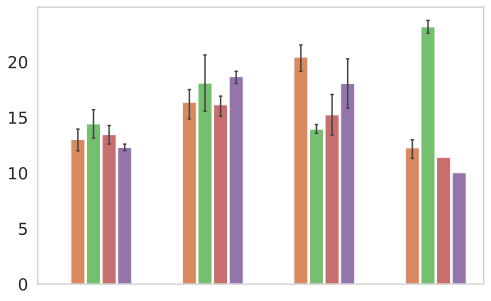

In [9]:
# Remove rows where time_exfiltrated is 0
filtered_ics_data = ics_data[ics_data['percent_hosts_infected'] > 90]

plt.figure(figsize=(8, 5))
defender_order = ['basic_honeypot', 'mixed_deception', 'layered', 'reactive_simple']
attacker_order = ['equifax_baseline', 'network_DFS', 'darkside', 'targeted', 'persistent_dfs_planner']
sns.barplot(x='defender', y='time_taken', hue='attacker', data=filtered_ics_data,
            order=defender_order, hue_order=attacker_order,
            width=.7, legend=False, gap=0.1, dodge=True, estimator='mean',
            err_kws={'linewidth': 1.5}, capsize=0.1)

plt.gca().set(xlabel=None, ylabel=None)  # Removes axis labels
# Hide x axis tick labels
plt.xticks([], [])
# Save as SVG file
plt.savefig('plots/ics_bar_summary.svg', format='svg')

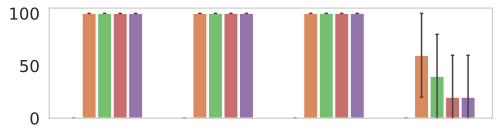

In [10]:
# Remove rows where time_exfiltrated is 0
plt.figure(figsize=(8, 2))
defender_order = ['basic_honeypot', 'mixed_deception', 'layered', 'reactive_simple']
attacker_order = ['equifax_baseline', 'network_DFS', 'darkside', 'targeted', 'persistent_dfs_planner']
sns.barplot(x='defender', y='percent_hosts_infected', hue='attacker', data=ics_data,
            order=defender_order, hue_order=attacker_order,
            width=.7, legend=False, gap=0.1, dodge=True, estimator='mean',
            err_kws={'linewidth': 1.5}, capsize=0.1)

plt.gca().set(xlabel=None, ylabel=None)  # Removes axis labels
# Hide x axis tick labels
plt.xticks([], [])
# Save as SVG file
plt.savefig('plots/ics_bar_goal_summary.svg', format='svg')

In [13]:
filtered_ics_data

,experiment,defender,attacker,experiment_num,hosts_infected,percent_hosts_infected,time_taken,time_per_host
5,dfs_standalone_d10_h0,basic_honeypot,network_DFS,5,5,100.0,13.924479,8.173156
6,dfs_standalone_d10_h0,basic_honeypot,network_DFS,6,5,100.0,14.004719,9.163209
7,dfs_standalone_d10_h0,basic_honeypot,network_DFS,7,5,100.0,11.916620,7.313466
8,dfs_standalone_d10_h0,basic_honeypot,network_DFS,8,5,100.0,11.347186,7.296891
9,dfs_standalone_d10_h0,basic_honeypot,network_DFS,9,5,100.0,13.925333,10.159262
...,...,...,...,...,...,...,...,...
9,dfs_reactiveSimple,reactive_simple,network_DFS,9,5,100.0,12.488077,9.428538
13,equifax_reactiveSimple,reactive_simple,targeted,13,5,100.0,11.414193,6.815270
18,persistentdfs_reactiveSimple,reactive_simple,persistent_dfs_planner,18,5,100.0,10.031501,7.308901
21,darkside_reactiveSimple,reactive_simple,darkside,21,5,100.0,23.738794,17.330737
